# **Face Recognition Using PCA & LDA**


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

## Generate the Data Matrix and the Label vector


In [3]:
paths = ["datasets/s" + str(i) for i in range(1, 41)]
cnt = 0
Data = np.zeros((400, 10304))
labels = np.zeros((400, 1))
for i in range(40):
    labels[i * 10 : (i + 1) * 10] = i + 1
for path in paths:
    files = os.listdir(path)
    for file in files:
        img = Image.open(path + "/" + file)
        np_img = np.array(img)
        np_img = np_img.flatten()
        Data[cnt] = np_img
        cnt += 1

### Data Visualization


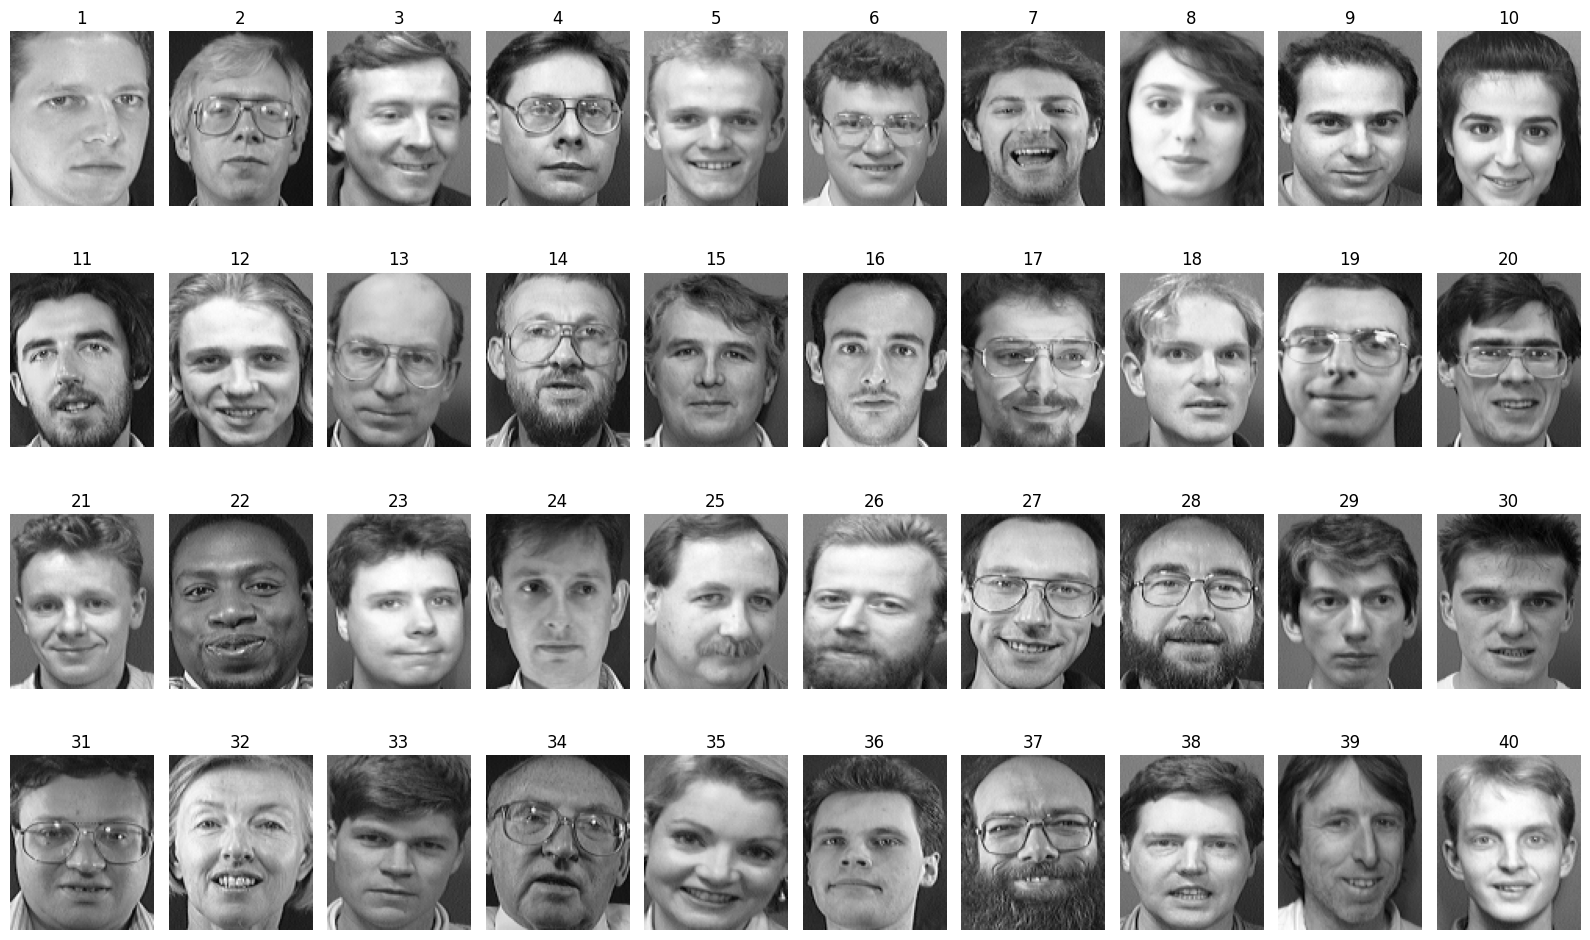

In [4]:
image_height = 112
image_width = 92

fig, axs = plt.subplots(4, 10, figsize=(16, 10))

# Flatten the array of axes
axs = axs.ravel()

for i in range(40):
    image_array = np.reshape(Data[(i) * 10], (image_height, image_width))
    axs[i].imshow(image_array, cmap="gray")
    axs[i].set_title(i + 1)
    axs[i].axis("off")

plt.tight_layout()
plt.show()

## Splitting The Dataset


In [5]:
X_train = Data[0::2]
X_test = Data[1::2]
y_train = labels[0::2]
y_test = labels[1::2]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(200, 10304)
(200, 10304)
(200, 1)
(200, 1)


## PCA


In [6]:
def get_PCA(X_train, alpha):
    # Compute the mean of the training data
    mean_face = np.mean(X_train, axis=0)
    # subtract the mean from the training data
    X_train_centralized = X_train - mean_face
    # compute the covariance matrix
    cov_matrix = X_train_centralized @ X_train_centralized.T
    # compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    # sort the eigenvectors descindigly by eigenvalues
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    # restore the original eigenvectors
    eigenvectors_converted = X_train_centralized.T @ eigenvectors
    # normalize the eigenvectors_converted
    eigenfaces = eigenvectors_converted / np.linalg.norm(eigenvectors_converted, axis=0)
    # compute the number of components to keep
    sum = 0
    no_components = 0
    for i in range(len(eigenvalues)):
        sum += eigenvalues[i]
        no_components += 1
        if sum / np.sum(eigenvalues) >= alpha:
            break
    # project the training data on the eigenfaces
    X_train_pca = X_train_centralized @ eigenfaces[:, :no_components]
    return X_train_pca, mean_face, eigenfaces[:, :no_components]

## Plotting The first 5 Eigen Faces

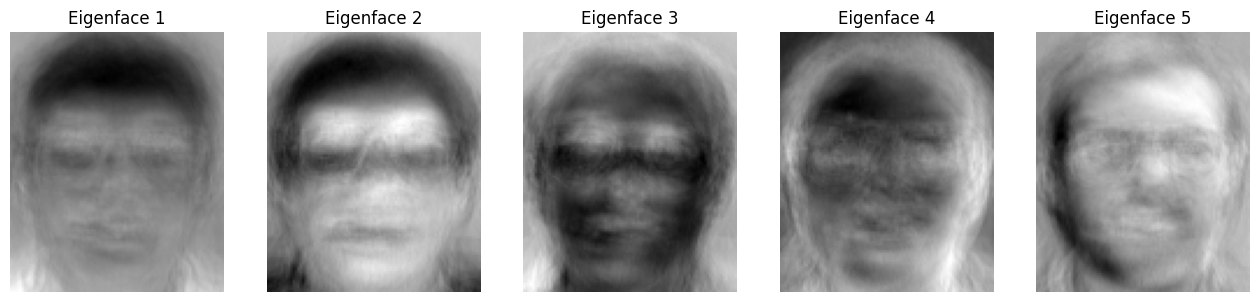

In [7]:
X_train_pca, mean_face, eigenfaces = get_PCA(X_train, 0.95)
# plotting first 5 eigenfaces
fig, axs = plt.subplots(1, 5, figsize=(16, 10))
for i in range(5):
    image_array = np.reshape(eigenfaces[:, i], (image_height, image_width))
    axs[i].imshow(image_array, cmap="gray")
    axs[i].set_title("Eigenface " + str(i + 1))
    axs[i].axis("off")

### Test PCA


In [8]:
def Test_PCA(alpha, k):
    X_train_pca, mean_face, eigenfaces = get_PCA(X_train, alpha)
    X_test_centralized = X_test - mean_face
    X_test_pca = X_test_centralized @ eigenfaces
    knn = KNeighborsClassifier(k, weights="distance")
    knn.fit(X_train_pca, y_train.ravel())
    y_pred = knn.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred.ravel())
    return accuracy


print("PCA Accuracy: " + str(Test_PCA(0.85, 1)))

PCA Accuracy: 0.95


## Classifier Tuning for PCA


In [9]:
alphas = [0.8, 0.85, 0.9, 0.95]
k_values = [1, 3, 5, 7, 9]
df = pd.DataFrame(index=alphas, columns=k_values)
for num_dominant_eigen_vectors in alphas:
    for k in k_values:
        accuracy = Test_PCA(num_dominant_eigen_vectors, k)
        df.loc[num_dominant_eigen_vectors, k] = accuracy

df

,1,3,5,7,9
0.80,0.95,0.925,0.91,0.885,0.86
0.85,0.95,0.925,0.905,0.885,0.84
0.90,0.945,0.925,0.895,0.88,0.84
0.95,0.945,0.925,0.895,0.875,0.805


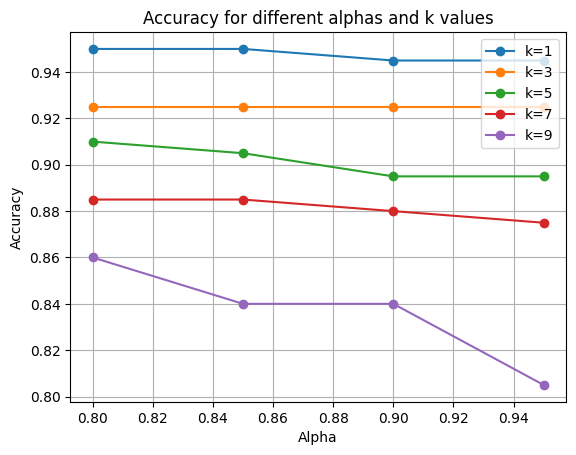

In [10]:
for k in k_values:
    plt.plot(df.index, df[k], marker="o", label=f"k={k}")

plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Accuracy for different alphas and k values")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# LDA


In [11]:
def get_LDA(X_train):

    # Computing the overall mean
    overall_mean = np.mean(X_train, axis=0).reshape(10304, 1)

    # Computing the between-class & within-class scatter matrix
    S_B = np.zeros((10304, 10304))
    S_W = np.zeros((10304, 10304))

    for i in range(1, 41):
        # Computing the mean of each class
        class_mean = np.mean(X_train[(i - 1) * 5 : i * 5], axis=0)

        # Reshaping the mean to be a column vector
        class_mean = class_mean.reshape(10304, 1)

        # Computing the between-class scatter matrix by summing the outer products of the difference between the class mean and the overall mean
        S_B += 5 * np.dot((class_mean - overall_mean), (class_mean - overall_mean).T)

        # Computing the centered data
        centered_data = X_train[(i - 1) * 5 : i * 5] - np.mean(
            X_train[(i - 1) * 5 : i * 5], axis=0
        )

        # Computing the within-class scatter matrix by summing the outer products of the centered data
        S_W += np.dot(centered_data.T, centered_data)

    # Computing the total projection matrix
    S = np.dot(np.linalg.inv(S_W), S_B)

    # Computing the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(S)

    idx = eigenvalues.argsort()[::-1]
    sorted_eigenvectors = eigenvectors[:, idx]

    # Taking only the dominant eigenvectors
    projection_matrix = sorted_eigenvectors[:, :39]

    return projection_matrix

### Test LDA


In [12]:
def Test_LDA(k):
 projection_matrix = get_LDA(X_train)
 projected_X_train = np.dot(X_train, projection_matrix)
 projected_X_test = np.dot(X_test, projection_matrix)

 knn = KNeighborsClassifier(n_neighbors=k)
 knn.fit(projected_X_train, y_train.ravel())
 y_pred = knn.predict(projected_X_test)
 accuracy = accuracy_score(y_test, y_pred.ravel())
 return accuracy
print("LDA Accuracy: " + str(Test_LDA(1)))

: 

## Classifier Tuning for LDA


In [ ]:
k_values = [1, 3, 5, 7, 9]

# Initialize a list to store the results
results = []

# Loop over the values of k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights="distance")
    knn.fit(projected_X_train, y_train.ravel())
    y_pred = knn.predict(projected_X_test)
    accuracy = accuracy_score(y_test, y_pred.ravel())
    results.append({"accuracy": accuracy})

# Convert the results to a DataFrame
df = pd.DataFrame(results, index=k_values)
df.index.name = "k"
df

,accuracy
k,
1,0.955
3,0.915
5,0.890
7,0.860
9,0.845


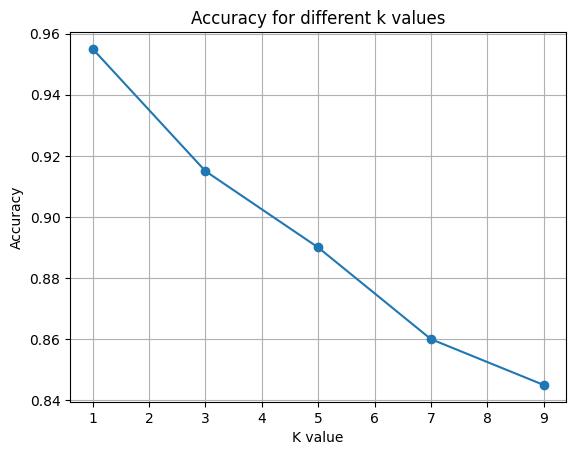

In [ ]:
plt.plot(df, marker="o")
plt.xlabel("K value")
plt.ylabel("Accuracy")
plt.title("Accuracy for different k values")
plt.grid(True)
plt.show()

## Comparison Between PCA & LDA


### Accuracy of PCA VS LDA with respect to K (in KNN) 

In [17]:
# PCA
alpha=0.85
k_values = [1, 3, 5, 7, 9]
pca_results = []
variants=['PCA', 'LDA']
df = pd.DataFrame(index=variants, columns=k_values)
for num_dominant_eigen_vectors in alphas:
    for k in k_values:
        pca_accuracy = Test_PCA(alpha, k)
        lda_accuracy = Test_LDA(k)
        df.loc['PCA', k] = str(pca_accuracy*100)+'%'
        

,1,3,5,7,9
PCA,95.0%,92.5%,90.5%,88.5%,84.0%
LDA,NaN,NaN,NaN,NaN,NaN


## Variant of PCA


## Variant of LDA
